In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_data(df, scaler=None, fit_scaler=True):
    """
    Preprocess the compressor data
    """
    # Convert timestamp to datetime if it's not already
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp')
    
    # Select only numeric columns (excluding timestamp and compressor_id)
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'compressor_id' in numeric_columns:
        numeric_columns.remove('compressor_id')
    
    # Fill any missing values
    df[numeric_columns] = df[numeric_columns].fillna(method='ffill')
    
    # Initialize scaler if not provided
    if scaler is None:
        scaler = StandardScaler()
    
    # Normalize the data
    if fit_scaler:
        scaled_data = scaler.fit_transform(df[numeric_columns])
    else:
        scaled_data = scaler.transform(df[numeric_columns])
    
    return scaled_data, numeric_columns, scaler


In [3]:
def create_sequences(data, sequence_length):
    """
    Create sequences for LSTM training
    """
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:(i + sequence_length)])
    return np.array(sequences)


def build_lstm_autoencoder(sequence_length, n_features, encoding_dim=32, learning_rate=0.001):
    """
    Build the LSTM Autoencoder model
    """
    # Input layer
    input_layer = Input(shape=(sequence_length, n_features))
    
    # Encoder
    encoded = LSTM(encoding_dim, activation='relu', return_sequences=False)(input_layer)
    
    # Decoder
    decoded = RepeatVector(sequence_length)(encoded)
    decoded = LSTM(encoding_dim, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features, activation='linear'))(decoded)
    
    # Create and compile model
    model = Model(input_layer, decoded)
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='mse', 
                  metrics=['mae'])
    
    return model


def train_on_normal_data(normal_df, sequence_length=10, encoding_dim=32, 
                        learning_rate=0.001, epochs=100, batch_size=32, 
                        validation_split=0.2, verbose=1):
    """
    Train the LSTM autoencoder on NORMAL operating data only
    
    This teaches the model what "normal" looks like.
    Any deviation from this learned pattern will have high reconstruction error.
    
    Returns:
    - model: Trained autoencoder model
    - scaler: Fitted data scaler
    - threshold: Anomaly detection threshold
    - feature_columns: List of feature column names
    - history: Training history
    """
    print("="*70)
    print("TRAINING ON NORMAL DATA")
    print("="*70)
    print("\nPreprocessing normal operating data...")
    
    # Preprocess normal data
    scaled_data, feature_columns, scaler = preprocess_data(normal_df, fit_scaler=True)
    
    # Create sequences
    sequences = create_sequences(scaled_data, sequence_length)
    
    print(f"\nDataset Statistics:")
    print(f"  Total samples: {len(normal_df)}")
    print(f"  Features: {len(feature_columns)}")
    print(f"  Sequences created: {len(sequences)}")
    print(f"  Sequence shape: {sequences.shape}")
    print(f"\nFeatures being monitored:")
    for i, col in enumerate(feature_columns, 1):
        print(f"  {i}. {col}")
    
    # Build model
    model = build_lstm_autoencoder(sequence_length, scaled_data.shape[1], 
                                  encoding_dim, learning_rate)
    
    print(f"\n" + "="*70)
    print("Model Architecture:")
    print("="*70)
    model.summary()
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train model on normal data
    print("\n" + "="*70)
    print("Training autoencoder to learn normal behavior...")
    print("="*70)
    history = model.fit(
        sequences, sequences, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=validation_split,
        callbacks=[early_stop],
        verbose=verbose,
        shuffle=True
    )
    
    # Calculate threshold from training data
    # We use validation split to set threshold to avoid overfitting
    print("\n" + "="*70)
    print("Calculating anomaly threshold...")
    print("="*70)
    
    train_predictions = model.predict(sequences, verbose=0)
    train_mse = np.mean(np.power(sequences - train_predictions, 2), axis=(1, 2))
    
    # Use higher percentile (95-99) to minimize false positives
    # Lower percentile = more sensitive (more anomalies detected)
    # Higher percentile = less sensitive (fewer false alarms)
    threshold_percentile = 99  # Changed from 95 to 99 for stricter threshold
    threshold = np.percentile(train_mse, threshold_percentile)
    
    print(f"\nReconstruction Error on Normal Data:")
    print(f"  Mean: {train_mse.mean():.6f}")
    print(f"  Std:  {train_mse.std():.6f}")
    print(f"  Min:  {train_mse.min():.6f}")
    print(f"  Max:  {train_mse.max():.6f}")
    print(f"  95th percentile: {np.percentile(train_mse, 95):.6f}")
    print(f"  99th percentile: {np.percentile(train_mse, 99):.6f}")
    print(f"\n✓ Threshold set at {threshold_percentile}th percentile: {threshold:.6f}")
    print(f"  (Any test data with reconstruction error > {threshold:.6f} is anomalous)")
    
    return model, scaler, threshold, feature_columns, history

In [4]:
def test_on_data(model, scaler, threshold, feature_columns, test_df, 
                sequence_length=10, consecutive_threshold=3, data_label="Test"):
    """
    Test the trained model on new data (could be normal or anomalous)
    
    The model will compare test data to what it learned as "normal".
    High reconstruction error = data doesn't match normal patterns = ANOMALY
    
    Parameters:
    - consecutive_threshold: Number of consecutive anomalous points to trigger alert
    - data_label: Label for this dataset (e.g., "Normal Test", "Fault Condition")
    
    Returns:
    - results: DataFrame with anomaly detection results including feature-level errors
    """
    print("\n" + "="*70)
    print(f"TESTING ON {data_label.upper()} DATA")
    print("="*70)
    
    # Preprocess test data using SAME scaler from training
    scaled_data, _, _ = preprocess_data(test_df, scaler=scaler, fit_scaler=False)
    
    # Create sequences
    sequences = create_sequences(scaled_data, sequence_length)
    
    print(f"Test sequences created: {len(sequences)}")
    
    # Get model predictions (reconstruction)
    print("Reconstructing sequences...")
    predictions = model.predict(sequences, verbose=0)
    
    # Calculate overall reconstruction error (how different is test data from normal?)
    mse = np.mean(np.power(sequences - predictions, 2), axis=(1, 2))
    
    # Calculate FEATURE-LEVEL reconstruction errors
    # Shape: (n_sequences, n_features)
    feature_mse = np.mean(np.power(sequences - predictions, 2), axis=1)
    
    # Determine individual anomalies (points exceeding threshold)
    is_anomaly_point = mse > threshold
    
    # Apply consecutive threshold logic for robust detection
    triggered_anomaly = np.zeros(len(mse), dtype=bool)
    consecutive_count = 0
    
    for i in range(len(is_anomaly_point)):
        if is_anomaly_point[i]:
            consecutive_count += 1
            # If we've hit consecutive threshold, mark all points in window as triggered
            if consecutive_count >= consecutive_threshold:
                start_idx = max(0, i - consecutive_count + 1)
                triggered_anomaly[start_idx:i+1] = True
        else:
            consecutive_count = 0
    
    # Create results dataframe
    results = pd.DataFrame({
        'sequence_index': range(len(mse)),
        'reconstruction_error': mse,
        'threshold': threshold,
        'is_anomaly_point': is_anomaly_point,
        'triggered_anomaly': triggered_anomaly,
        'anomaly_score': mse / threshold,  # >1.0 means anomalous
        'consecutive_count': 0
    })
    
    # Add feature-level errors as separate columns
    for i, col in enumerate(feature_columns):
        results[f'error_{col}'] = feature_mse[:, i]
    
    # Calculate consecutive count for each point
    consecutive = 0
    for i in range(len(results)):
        if is_anomaly_point[i]:
            consecutive += 1
        else:
            consecutive = 0
        results.loc[i, 'consecutive_count'] = consecutive
    
    # Map back to original timestamps if available
    if 'timestamp' in test_df.columns:
        start_idx = sequence_length - 1
        results['timestamp'] = test_df['timestamp'].iloc[start_idx:start_idx + len(results)].values
    
    # Print summary
    print_test_summary(results, data_label, consecutive_threshold)
    
    # Analyze which features are most anomalous
    analyze_anomalous_features(results, feature_columns, triggered_anomaly)
    
    return results


In [5]:
def analyze_anomalous_features(results, feature_columns, triggered_anomaly):
    """
    Analyze which features contribute most to anomalies
    """
    if triggered_anomaly.sum() == 0:
        return
    
    print(f"\n{'='*70}")
    print("ANOMALOUS FEATURE ANALYSIS")
    print(f"{'='*70}")
    
    # Get feature error columns
    error_cols = [f'error_{col}' for col in feature_columns]
    
    # Calculate mean error for each feature during anomalies
    anomaly_feature_errors = results[triggered_anomaly][error_cols].mean()
    normal_feature_errors = results[~triggered_anomaly][error_cols].mean()
    
    # Calculate relative increase
    feature_contribution = pd.DataFrame({
        'feature': feature_columns,
        'normal_error': normal_feature_errors.values,
        'anomaly_error': anomaly_feature_errors.values,
        'increase_ratio': (anomaly_feature_errors / (normal_feature_errors + 1e-10)).values,
        'contribution_pct': 100 * anomaly_feature_errors / anomaly_feature_errors.sum()
    })
    
    # Sort by contribution percentage
    feature_contribution = feature_contribution.sort_values('contribution_pct', ascending=False)
    
    print("\nTop Contributing Features to Anomalies:")
    print("-" * 70)
    print(f"{'Rank':<6}{'Feature':<35}{'Contribution':<15}{'Increase':<15}")
    print("-" * 70)
    
    for i, (idx, row) in enumerate(feature_contribution.head(10).iterrows(), 1):
        print(f"{i:<6}{row['feature']:<35}{row['contribution_pct']:>6.2f}%{' '*8}{row['increase_ratio']:>6.2f}x")
    
    return feature_contribution


In [6]:
def print_test_summary(results, data_label, consecutive_threshold):
    """
    Print summary of test results
    """
    total_points = len(results)
    anomaly_points = results['is_anomaly_point'].sum()
    triggered_points = results['triggered_anomaly'].sum()
    
    print(f"\n{'='*70}")
    print(f"RESULTS SUMMARY - {data_label}")
    print(f"{'='*70}")
    print(f"Total sequences analyzed: {total_points}")
    print(f"Points exceeding threshold: {anomaly_points} ({100*anomaly_points/total_points:.2f}%)")
    print(f"Triggered alerts (≥{consecutive_threshold} consecutive): {triggered_points} ({100*triggered_points/total_points:.2f}%)")
    
    print(f"\nReconstruction Error Statistics:")
    print(f"  Mean:   {results['reconstruction_error'].mean():.6f}")
    print(f"  Median: {results['reconstruction_error'].median():.6f}")
    print(f"  Std:    {results['reconstruction_error'].std():.6f}")
    print(f"  Min:    {results['reconstruction_error'].min():.6f}")
    print(f"  Max:    {results['reconstruction_error'].max():.6f}")
    
    print(f"\nAnomaly Score Statistics (score > 1.0 = anomaly):")
    print(f"  Mean:   {results['anomaly_score'].mean():.3f}")
    print(f"  Median: {results['anomaly_score'].median():.3f}")
    print(f"  Max:    {results['anomaly_score'].max():.3f}")
    
    if triggered_points > 0:
        print(f"\n⚠️  ANOMALIES DETECTED!")
        print(f"   {triggered_points} sequences triggered anomaly alerts")
        
        # Show when anomalies occurred
        triggered = results[results['triggered_anomaly']]
        if 'timestamp' in triggered.columns:
            print(f"\n   First anomaly: {triggered['timestamp'].iloc[0]}")
            print(f"   Last anomaly:  {triggered['timestamp'].iloc[-1]}")
    else:
        print(f"\n✓ No anomalies detected - system operating normally")

In [7]:
def plot_training_history(history):
    """
    Plot training and validation loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_title('Model Loss - Learning Normal Behavior')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('Model MAE - Learning Normal Behavior')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [8]:
def plot_feature_contributions(results, feature_columns, title="Feature-Level Anomaly Analysis"):
    """
    Plot which features contribute most to anomalies
    """
    # Get only triggered anomalies
    if results['triggered_anomaly'].sum() == 0:
        print("No anomalies to analyze")
        return None
    
    anomaly_data = results[results['triggered_anomaly']]
    normal_data = results[~results['triggered_anomaly']]
    
    # Calculate mean errors per feature
    error_cols = [f'error_{col}' for col in feature_columns]
    
    anomaly_errors = anomaly_data[error_cols].mean().values
    normal_errors = normal_data[error_cols].mean().values if len(normal_data) > 0 else np.zeros(len(error_cols))
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Bar chart of feature contributions
    x_pos = np.arange(len(feature_columns))
    
    ax1.bar(x_pos, anomaly_errors, alpha=0.7, color='red', label='Anomaly Periods')
    ax1.bar(x_pos, normal_errors, alpha=0.7, color='green', label='Normal Periods')
    
    ax1.set_xlabel('Features', fontsize=12)
    ax1.set_ylabel('Mean Reconstruction Error', fontsize=12)
    ax1.set_title('Reconstruction Error by Feature', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(feature_columns, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Sorted contribution percentage
    contribution_pct = 100 * anomaly_errors / anomaly_errors.sum()
    sorted_idx = np.argsort(contribution_pct)[::-1]
    
    colors = ['red' if c > 100/len(feature_columns) else 'orange' for c in contribution_pct[sorted_idx]]
    
    ax2.barh(range(len(feature_columns)), contribution_pct[sorted_idx], color=colors, alpha=0.7)
    ax2.set_yticks(range(len(feature_columns)))
    ax2.set_yticklabels([feature_columns[i] for i in sorted_idx])
    ax2.set_xlabel('Contribution to Total Anomaly (%)', fontsize=12)
    ax2.set_title('Feature Contribution Ranking', fontsize=14, fontweight='bold')
    ax2.axvline(x=100/len(feature_columns), color='black', linestyle='--', 
                linewidth=1, label=f'Average ({100/len(feature_columns):.1f}%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig


In [9]:
def plot_test_results(results, threshold, title="Anomaly Detection Results", 
                     consecutive_threshold=3):
    """
    Plot the test results showing anomaly detection
    """
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot 1: Reconstruction Error
    ax1 = axes[0]
    ax1.plot(results.index, results['reconstruction_error'], 
             label='Reconstruction Error', alpha=0.8, color='blue', linewidth=1.5)
    ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2,
                label=f'Threshold = {threshold:.4f}')
    
    # Shade individual anomaly points
    ax1.fill_between(results.index, 0, results['reconstruction_error'], 
                     where=results['is_anomaly_point'], alpha=0.3, 
                     color='orange', label='Exceeds Threshold')
    
    # Highlight triggered anomalies
    ax1.fill_between(results.index, 0, results['reconstruction_error'], 
                     where=results['triggered_anomaly'], alpha=0.5, 
                     color='red', label=f'TRIGGERED ALERT')
    
    ax1.set_ylabel('Reconstruction Error', fontsize=12)
    ax1.set_title('Reconstruction Error: Deviation from Normal Behavior', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Anomaly Score (Normalized)
    ax2 = axes[1]
    ax2.plot(results.index, results['anomaly_score'], 
             label='Anomaly Score', color='darkorange', linewidth=1.5)
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2,
                label='Anomaly Threshold (1.0)')
    
    # Shade triggered anomalies
    ax2.fill_between(results.index, 0, results['anomaly_score'], 
                     where=results['triggered_anomaly'], alpha=0.5, 
                     color='red', label=f'TRIGGERED ALERT')
    
    ax2.set_ylabel('Anomaly Score\n(Reconstruction Error / Threshold)', fontsize=12)
    ax2.set_title('Normalized Anomaly Score (>1.0 = Anomalous)', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Consecutive Anomaly Counter
    ax3 = axes[2]
    colors = ['green' if c < consecutive_threshold else 'red' 
              for c in results['consecutive_count']]
    ax3.bar(results.index, results['consecutive_count'], 
            color=colors, alpha=0.6, width=1.0)
    ax3.axhline(y=consecutive_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Trigger Level = {consecutive_threshold}')
    
    ax3.set_ylabel('Consecutive\nAnomalous Points', fontsize=12)
    ax3.set_xlabel('Time Step (Sequence Index)', fontsize=12)
    ax3.set_title(f'Consecutive Anomaly Counter (Alert when ≥ {consecutive_threshold})', 
                 fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    return fig


In [11]:
def main():
    """
    Main workflow:
    1. Train on ALL normal data to learn normal behavior
    2. Test on separate data (normal or anomalous) to detect deviations
    """
    print("\n" + "="*70)
    print(" LSTM AUTOENCODER - ANOMALY DETECTION FOR COMPRESSOR ")
    print("="*70)
    print("\nWorkflow:")
    print("  1. Train on NORMAL operating data (learn baseline)")
    print("  2. Test on new data (detect deviations from baseline)")
    print("="*70)
    
    # ==========================================
    # STEP 1: TRAIN ON NORMAL DATA
    # ==========================================
    print("\n📊 Loading normal operating data...")
    normal_df = pd.read_csv("D:\compressor_normal_dataset2.csv")
    print(f"   Loaded {len(normal_df)} normal samples")
    
    # Training parameters
    sequence_length = 10
    consecutive_threshold = 4  # Need 4 consecutive anomalies to trigger alert
    
    # Train model to learn normal behavior
    model, scaler, threshold, feature_columns, history = train_on_normal_data(
        normal_df,
        sequence_length=sequence_length,
        encoding_dim=16,
        learning_rate=0.001,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        verbose=1
    )
    
    # Plot training progress
    print("\n📈 Plotting training history...")
    plot_training_history(history)
    
    # ==========================================
    # STEP 2: TEST ON NEW DATA
    # ==========================================
    
    # Option A: Test on normal data (should have low reconstruction error)
    print("\n" + "="*70)
    print("TESTING PHASE")
    print("="*70)
    print("\n🔍 Testing on normal data (validation check)...")
    
    # Use a portion of normal data for validation
    test_normal_df = pd.read_csv("D:\compressor_E_dataset.csv")

    #test_normal_df = normal_df.iloc[int(0.8*len(normal_df)):].copy()
    
    results_normal = test_on_data(
        model, scaler, threshold, feature_columns,
        test_normal_df,
        sequence_length=sequence_length,
        consecutive_threshold=consecutive_threshold,
        data_label="Normal Data (Validation)"
    )
    
    plot_test_results(results_normal, threshold,
                     title="Testing on Normal Data - Should Have Low Errors",
                     consecutive_threshold=consecutive_threshold)
    
    # Option B: Test on anomalous data (you need to provide this)
    print("\n" + "="*70)
    print("TO TEST ON ANOMALOUS DATA:")
    print("="*70)
    print("\nLoad your fault/anomaly dataset and run:")
    print("```python")
    print("anomaly_df = pd.read_csv('your_anomaly_data.csv')")
    print("results_anomaly = test_on_data(")
    print("    model, scaler, threshold, feature_columns,")
    print("    anomaly_df,")
    print("    sequence_length=sequence_length,")
    print("    consecutive_threshold=consecutive_threshold,")
    print("    data_label='Fault Condition'")
    print(")")
    print("plot_test_results(results_anomaly, threshold,")
    print("                 title='Testing on Fault Data',")
    print("                 consecutive_threshold=consecutive_threshold)")
    print("```")
    
    return model, scaler, threshold, feature_columns, results_normal


 LSTM AUTOENCODER - ANOMALY DETECTION FOR COMPRESSOR 

Workflow:
  1. Train on NORMAL operating data (learn baseline)
  2. Test on new data (detect deviations from baseline)

📊 Loading normal operating data...
   Loaded 40000 normal samples
TRAINING ON NORMAL DATA

Preprocessing normal operating data...

Dataset Statistics:
  Total samples: 40000
  Features: 11
  Sequences created: 39991
  Sequence shape: (39991, 10, 11)

Features being monitored:
  1. filter_dp
  2. seal_gas_flow
  3. seal_gas_diff_pressure
  4. seal_gas_temp
  5. primary_vent_flow
  6. primary_vent_pressure
  7. secondary_seal_gas_flow
  8. separation_seal_gas_flow
  9. separation_seal_gas_pressure
  10. seal_gas_to_vent_diff_pressure
  11. encoding

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 11)         │           187 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,091 (15.98 KB)

 Trainable params: 4,091 (15.98 KB)

 Non-trainable params: 0 (0.00 B)


Training autoencoder to learn normal behavior...
Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.9106 - mae: 0.7572 - val_loss: 0.0019 - val_mae: 0.0313
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.8469 - mae: 0.7200 - val_loss: 9.5289e-04 - val_mae: 0.0236
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.8377 - mae: 0.7143 - val_loss: 5.1539e-04 - val_mae: 0.0172
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.8345 - mae: 0.7122 - val_loss: 0.0013 - val_mae: 0.0273
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.8330 - mae: 0.7112 - val_loss: 5.5575e-04 - val_mae: 0.0183
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8318 - mae: 0.7104 - val_loss: 3.8250e-04 - val_mae: 0.0164
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.8312 - mae: 0.7100 - val_loss: 0.0011 - val_mae: 0.0277
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.8305 - mae: 0.7097 - v

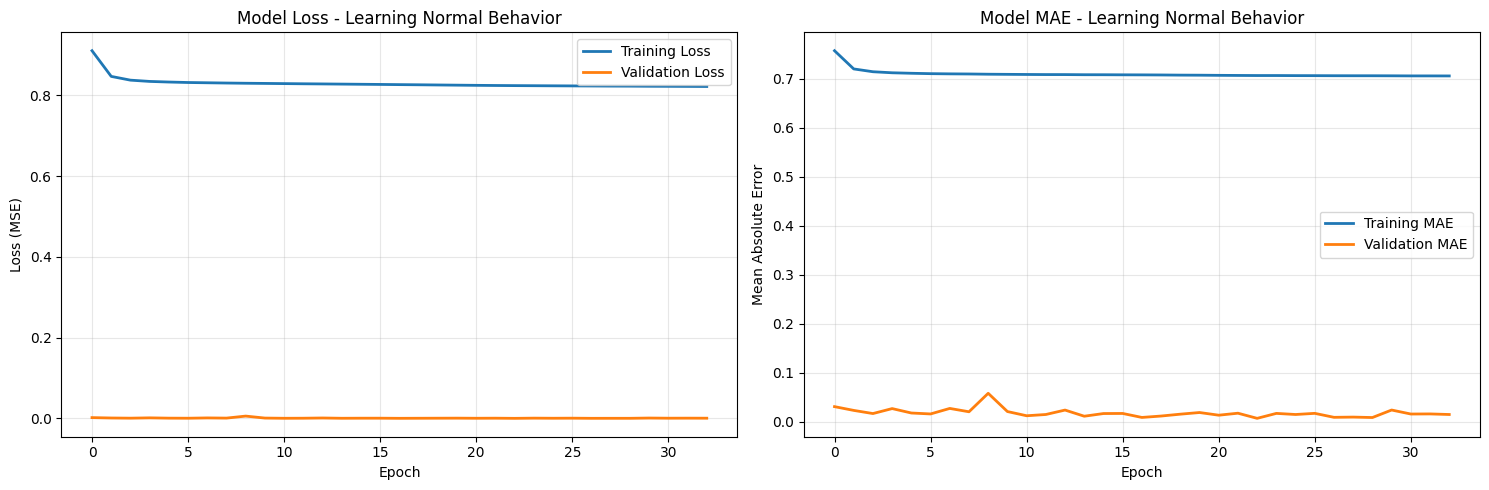


TESTING PHASE

🔍 Testing on normal data (validation check)...

TESTING ON NORMAL DATA (VALIDATION) DATA
Test sequences created: 191
Reconstructing sequences...

RESULTS SUMMARY - Normal Data (Validation)
Total sequences analyzed: 191
Points exceeding threshold: 111 (58.12%)
Triggered alerts (≥4 consecutive): 101 (52.88%)

Reconstruction Error Statistics:
  Mean:   1.724198
  Median: 1.236514
  Std:    1.145590
  Min:    0.640214
  Max:    6.221851

Anomaly Score Statistics (score > 1.0 = anomaly):
  Mean:   1.578
  Median: 1.132
  Max:    5.695

⚠️  ANOMALIES DETECTED!
   101 sequences triggered anomaly alerts

   First anomaly: 2025-09-26 00:09:00
   Last anomaly:  2025-09-26 03:19:00

ANOMALOUS FEATURE ANALYSIS

Top Contributing Features to Anomalies:
----------------------------------------------------------------------
Rank  Feature                            Contribution   Increase       
----------------------------------------------------------------------
1     seal_gas_temp  

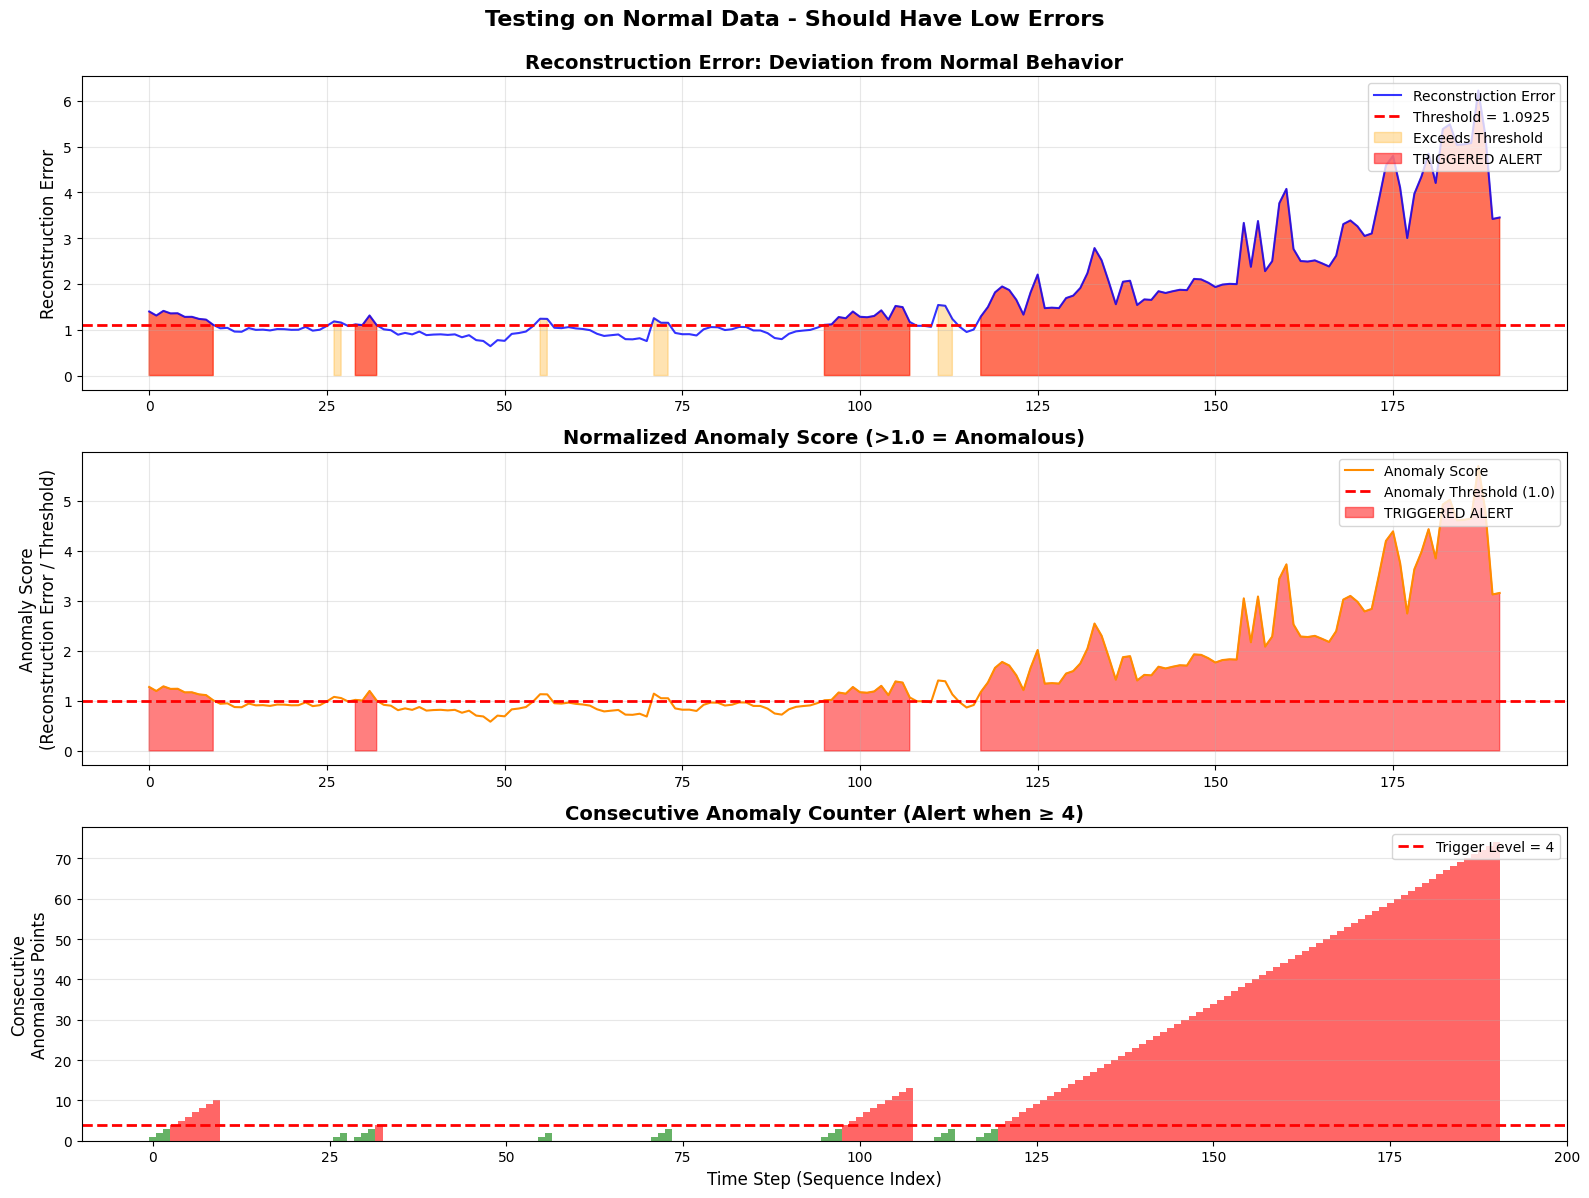


TO TEST ON ANOMALOUS DATA:

Load your fault/anomaly dataset and run:
```python
anomaly_df = pd.read_csv('your_anomaly_data.csv')
results_anomaly = test_on_data(
    model, scaler, threshold, feature_columns,
    anomaly_df,
    sequence_length=sequence_length,
    consecutive_threshold=consecutive_threshold,
    data_label='Fault Condition'
)
plot_test_results(results_anomaly, threshold,
                 title='Testing on Fault Data',
                 consecutive_threshold=consecutive_threshold)
```

💾 SAVING MODEL FOR DEPLOYMENT
✓ Model saved: compressor_autoencoder2.h5
✓ Scaler saved: scaler2.pkl
✓ Config saved: model_config2.pkl

📦 Model package ready for deployment!

To load and use later:
```python
from tensorflow.keras.models import load_model
import joblib

model = load_model('compressor_autoencoder2.h5')
scaler = joblib.load('scaler2.pkl')
config = joblib.load('model_config2.pkl')
threshold = config['threshold']
feature_columns = config['features']
```


In [12]:
if __name__ == "__main__":
    model, scaler, threshold, feature_columns, results = main()
    
    # Actually save the trained model for future use
    print("\n" + "="*70)
    print("💾 SAVING MODEL FOR DEPLOYMENT")
    print("="*70)
    
    import joblib
    
    # Save Keras model
    model.save('compressor_autoencoder2.h5')
    print("✓ Model saved: compressor_autoencoder2.h5")
    
    # Save scaler
    joblib.dump(scaler, 'scaler2.pkl')
    print("✓ Scaler saved: scaler2.pkl")
    
    # Save threshold and feature names
    joblib.dump({'threshold': threshold, 'features': feature_columns}, 'model_config2.pkl')
    print("✓ Config saved: model_config2.pkl")
    
    print("\n📦 Model package ready for deployment!")
    print("\nTo load and use later:")
    print("```python")
    print("from tensorflow.keras.models import load_model")
    print("import joblib")
    print("")
    print("model = load_model('compressor_autoencoder2.h5')")
    print("scaler = joblib.load('scaler2.pkl')")
    print("config = joblib.load('model_config2.pkl')")
    print("threshold = config['threshold']")
    print("feature_columns = config['features']")
    print("```")